In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import numpy as np
from scipy import signal
import pywt

# Please run data_download.py and data_preparation.py, before executing this notebook.

data_path = 'data'
maintenance_file = os.path.join('telemetry', 'PdM_maint.csv')
events_file = os.path.join(data_path, 'curated_events.csv')
telemetry_file = os.path.join(data_path, 'curated_telemetry.csv')
final_file = os.path.join(data_path, 'final.csv')

maintenance_events = pd.read_csv(maintenance_file, parse_dates=['datetime'])
curated_events = pd.read_csv(events_file, parse_dates=['datetime'])
curated_telemetry = pd.read_csv(telemetry_file, parse_dates=['datetime'])
final = pd.read_csv(final_file, parse_dates=['datetime'])

C:\Users\kevin\AppData\Local\Temp\ipykernel_26004\2881381432.py:18: DtypeWarning: Columns (126,127,128,129,130,131,132,133,134,148) have mixed types. Specify dtype option on import or set low_memory=False.
  final = pd.read_csv(final_file, parse_dates=['datetime'])



Calculated 3186 durations between maintenance events.
Duration Summary Statistics:
count    3186.000000
mean       16.947583
std        19.805651
min         0.000000
25%        15.000000
50%        15.000000
75%        15.000000
max       180.000000
Name: time_diff, dtype: float64


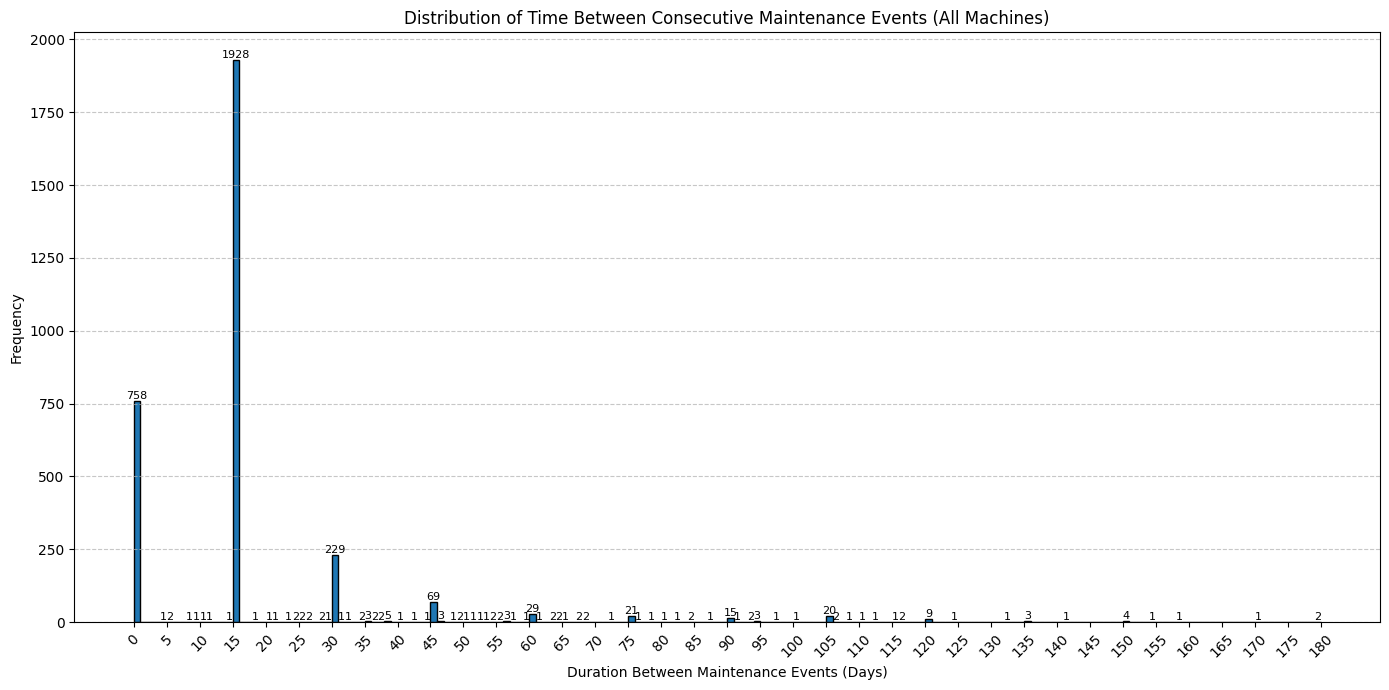

Saved maintenance duration histogram: plots\event_maintenance_duration_histogram_days.png


<Figure size 640x480 with 0 Axes>

In [3]:

def plot_maintenance_durations(maint_df, output_dir="plots", unit='days'):
    """
    Calculates the duration between consecutive maintenance events for each machine
    and plots a histogram of these durations.

    Parameters:
    -----------
    maint_df : pandas.DataFrame
        DataFrame containing maintenance events with 'machineID' and 'datetime'.
    output_dir : str, optional
        Directory to save the plot, by default "plots".
    unit : str, optional
        The unit for time duration ('days' or 'hours'), by default 'days'.
    """
    required_cols = ["machineID", "datetime"]
    if not all(col in maint_df.columns for col in required_cols):
        print(f"Error: Maintenance DataFrame missing required columns: {required_cols}.")
        return

    df = maint_df.copy()
    
    # Ensure datetime is sorted within each machine
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.sort_values(by=["machineID", "datetime"], inplace=True)

    # Calculate time difference between consecutive events per machine
    df['time_diff'] = df.groupby("machineID")['datetime'].diff()

    # Drop the first event for each machine (as it has no preceding event)
    valid_durations = df.dropna(subset=['time_diff'])

    if valid_durations.empty:
        print("Not enough consecutive maintenance events found to calculate durations.")
        return

    # Convert timedelta to the specified unit
    if unit == 'days':
        durations = valid_durations['time_diff'].dt.total_seconds() / (24 * 3600)
        x_label = f"Duration Between Maintenance Events ({unit.capitalize()})"
    elif unit == 'hours':
        durations = valid_durations['time_diff'].dt.total_seconds() / 3600
        x_label = f"Duration Between Maintenance Events ({unit.capitalize()})"
    else:
        print(f"Error: Invalid unit '{unit}'. Choose 'days' or 'hours'.")
        return
        
    print(f"\nCalculated {len(durations)} durations between maintenance events.")
    print("Duration Summary Statistics:")
    print(durations.describe())

    # Determine range for bins and ticks
    min_duration = 0 # Start bins/ticks from 0
    max_duration = math.ceil(durations.max()) # Round max duration up
    
    # Define bin edges with width 1
    bin_width = 1
    bins = np.arange(min_duration, max_duration + bin_width, bin_width)
    
    # Define tick locations with step 5
    tick_step = 5
    ticks = np.arange(min_duration, max_duration + tick_step, tick_step)

    # Plot histogram
    fig, ax = plt.subplots(figsize=(14, 7)) # Wider figure might be needed
    # Capture the counts and bin edges from hist()
    counts, bin_edges, patches = ax.hist(durations, bins=bins, edgecolor='black') 

    # Add text labels for counts above each bar
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    for count, x in zip(counts, bin_centers):
        if count > 0: # Only add text for non-empty bins
            ax.text(x, count, str(int(count)), ha='center', va='bottom', fontsize=8) 

    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel("Frequency")
    ax.set_title("Distribution of Time Between Consecutive Maintenance Events (All Machines)")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Set x-axis ticks
    ax.set_xticks(ticks)
    ax.tick_params(axis='x', rotation=45) # Rotate ticks if they overlap

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    plot_filename = os.path.join(output_dir, f"event_maintenance_duration_histogram_{unit}.png")
    
    plt.tight_layout()
    plt.show()
    plt.savefig(plot_filename)
    plt.close(fig)
    print(f"Saved maintenance duration histogram: {plot_filename}")

plot_maintenance_durations(maintenance_events, unit='days')

In [4]:

def print_intra_machine_duplicates_for_year(df_combined, machine_id):
    """
    Filters data for a specific year, then checks for and prints records
    that share the same timestamp within each individual machine.

    Parameters:
    -----------
    df_combined : pandas.DataFrame
        The combined DataFrame containing event/telemetry data with 'datetime' 
        and 'machineID' columns.
    year : int
        The year to filter the data for (e.g., 2015).
    """
    if 'datetime' not in df_combined.columns or 'machineID' not in df_combined.columns:
        print("Error: DataFrame must contain 'datetime' and 'machineID' columns.")
        return

    # Ensure datetime is in the correct format
    df = df_combined.copy()
    if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
        try:
            df['datetime'] = pd.to_datetime(df['datetime'])
        except Exception as e:
            print(f"Error converting 'datetime' column to datetime objects: {e}")
            return

    df = df[df['machineID']==machine_id]

    # Filter data for the specified year
    start_date = f"2015-01-01"
    end_date = f"2015-12-31"
    print(f"\nChecking for intra-machine duplicate timestamps between {start_date} and {end_date}...")
    
    try:
        df_year = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]
    except TypeError:
         print(f"Error filtering dates. Ensure 'datetime' column is comparable.")
         return

    if df_year.empty:
        print(f"No data found for the year {year}.")
        return

    found_any_duplicates = False
    grouped = df_year.groupby('machineID')

    for machine_id, machine_group in grouped:
        # keep=False marks ALL occurrences of duplicates
        duplicates = machine_group[machine_group.duplicated(subset=['datetime'], keep=False)]
        
        if not duplicates.empty:
            found_any_duplicates = True
            print(f"\n--- Duplicates found for Machine ID: {machine_id} ---")
            # Sort by datetime to see duplicates together
            print(duplicates.sort_values(by='datetime'))

    if not found_any_duplicates:
        print(f"\nNo records with duplicate timestamps found within any single machine for the year {year}.")
    else:
        print("\nFinished checking all machines.")

print_intra_machine_duplicates_for_year(maintenance_events, machine_id=1)



Checking for intra-machine duplicate timestamps between 2015-01-01 and 2015-12-31...

--- Duplicates found for Machine ID: 1 ---
              datetime  machineID   comp
4  2015-01-05 06:00:00          1  comp4
5  2015-01-05 06:00:00          1  comp1
6  2015-01-20 06:00:00          1  comp3
7  2015-01-20 06:00:00          1  comp1
8  2015-02-04 06:00:00          1  comp4
9  2015-02-04 06:00:00          1  comp3
15 2015-05-05 06:00:00          1  comp3
16 2015-05-05 06:00:00          1  comp2
20 2015-06-19 06:00:00          1  comp4
19 2015-06-19 06:00:00          1  comp1
24 2015-09-02 06:00:00          1  comp1
25 2015-09-02 06:00:00          1  comp4
27 2015-10-02 06:00:00          1  comp4
28 2015-10-02 06:00:00          1  comp1
29 2015-10-17 06:00:00          1  comp4
30 2015-10-17 06:00:00          1  comp2
31 2015-11-01 06:00:00          1  comp4
32 2015-11-01 06:00:00          1  comp2

Finished checking all machines.



Plotting CuratedEventType counts for machine 1...


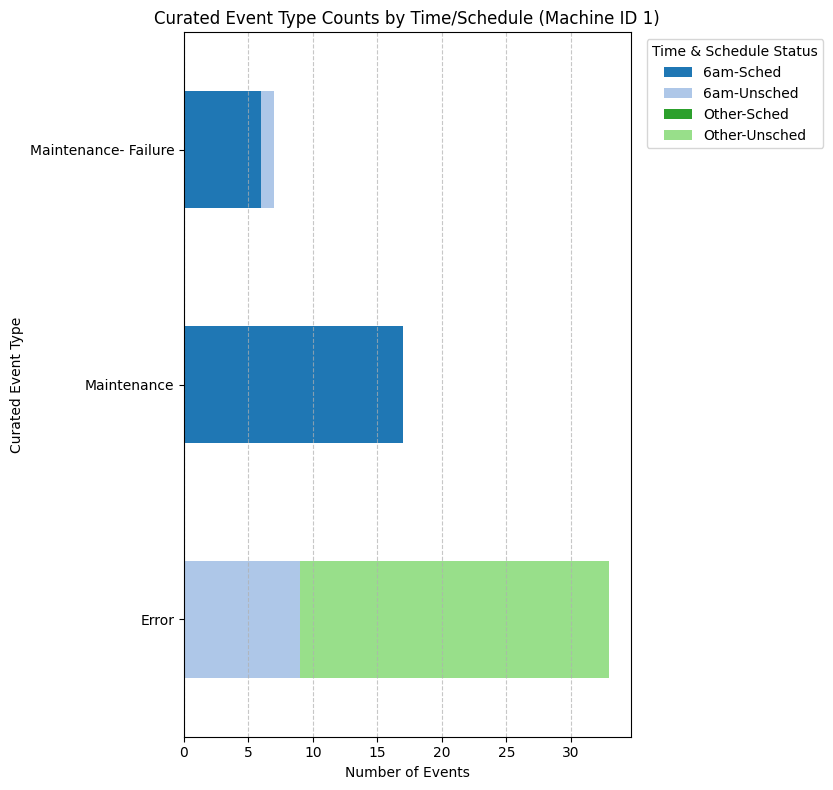

Saved curated event type counts plot: plots\event_curated_eventtype_counts_machine_1.png


In [7]:

def plot_curated_eventtype_counts(curated_pivoted_df, machine_id, output_dir="plots"):
    """
    Plots a horizontal stacked bar chart showing counts of CuratedEventType,
    colored by the combination of 6am status and scheduled status, for a specific machine.

    Parameters:
    -----------
    curated_pivoted_df : pandas.DataFrame
        DataFrame output from curate_pivoted_events, containing columns
        'machineID', 'CuratedEventType', 'is_6am', 'isScheduled'.
    machine_id : int
        The ID of the machine to plot.
    output_dir : str, optional
        Directory to save the plot, by default "plots".
    """
    required_cols = ['machineID', 'CuratedEventType', 'is_6am', 'isScheduled']
    if not all(col in curated_pivoted_df.columns for col in required_cols):
        print(f"Error: Input DataFrame missing one or more required columns for CuratedEventType plot: {required_cols}")
        return

    df_machine = curated_pivoted_df[curated_pivoted_df['machineID'] == machine_id].copy()

    if df_machine.empty:
        print(f"No curated pivoted data found for machine {machine_id} to plot CuratedEventType counts.")
        return

    print(f"\nPlotting CuratedEventType counts for machine {machine_id}...")

    # Create combined status column
    def get_status_category(row):
        time_part = "6am" if row['is_6am'] else "Other"
        sched_part = "Sched" if row['isScheduled'] else "Unsched"
        return f"{time_part}-{sched_part}"

    df_machine['status_category'] = df_machine.apply(get_status_category, axis=1)

    # Group by CuratedEventType and the new status category
    counts = df_machine.groupby(['CuratedEventType', 'status_category']).size().unstack(fill_value=0)

    # Define order and ensure all categories are present
    status_order = ['6am-Sched', '6am-Unsched', 'Other-Sched', 'Other-Unsched']
    counts = counts.reindex(columns=status_order, fill_value=0)

    # Filter out rows (CuratedEventTypes) where all counts are zero
    counts = counts[counts.sum(axis=1) > 0]

    if counts.empty:
        print(f"No non-zero CuratedEventType counts found for machine {machine_id} after grouping.")
        return

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8)) # Adjusted size for potentially more categories

    # Define colors for the 4 status categories
    colors = {
        '6am-Sched': '#1f77b4', # Blue
        '6am-Unsched': '#aec7e8', # Light Blue
        'Other-Sched': '#2ca02c', # Green
        'Other-Unsched': '#98df8a'  # Light Green
    }
    plot_colors = [colors[col] for col in counts.columns]

    # Plot stacked horizontal bar chart
    counts.plot(kind='barh', stacked=True, ax=ax, color=plot_colors)

    # Add labels and title
    ax.set_xlabel("Number of Events")
    ax.set_ylabel("Curated Event Type")
    ax.set_title(f"Curated Event Type Counts by Time/Schedule (Machine ID {machine_id})")
    ax.legend(title='Time & Schedule Status', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Add value labels (optional, can get crowded)
    # Consider adding only if counts are significant or total

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    plot_filename = os.path.join(output_dir, f"event_curated_eventtype_counts_machine_{machine_id}.png")

    try:
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout for legend
        plt.savefig(plot_filename)
        plt.show()
        print(f"Saved curated event type counts plot: {plot_filename}")
    except Exception as e:
        print(f"\nError saving curated event type counts plot: {e}")
    finally:
        plt.close(fig)

plot_curated_eventtype_counts(curated_events, machine_id=1, output_dir='plots')


Plotting event distribution by CuratedEventType by time of day...


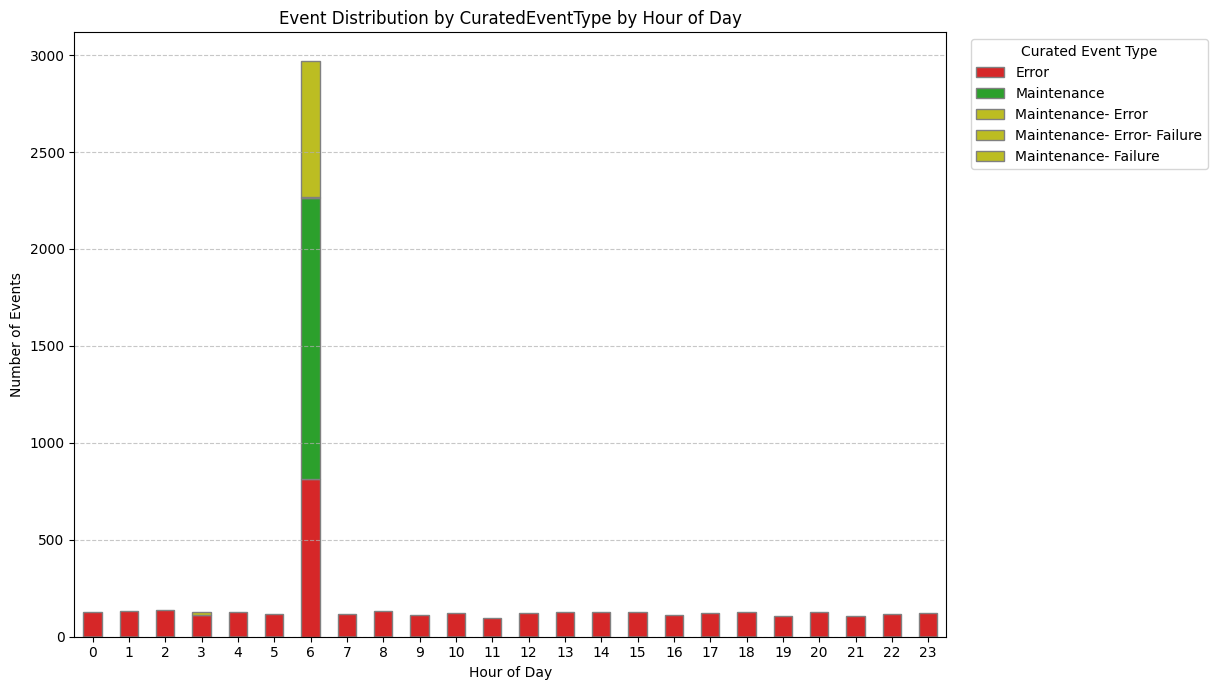

Saved event distribution by CuratedEventType by time of day: plots\event_by_curatedtype_by_timeofday.png


In [8]:

def plot_events_by_timeofday(df_pivoted, output_dir="plots"):
    """
    Plots the distribution of event records by hour of the day, stacked and colored
    by CuratedEventType.

    Parameters:
    -----------
    df_pivoted : pandas.DataFrame
        The curated pivoted DataFrame with 'datetime' and 'CuratedEventType'.
    output_dir : str, optional
        Directory to save the plot, by default "plots".
    """
    required_cols = ['datetime', 'CuratedEventType']
    if not all(col in df_pivoted.columns for col in required_cols):
        print(f"Error: DataFrame must contain required columns for hourly plot: {required_cols}")
        return

    df = df_pivoted.copy()
    # Ensure datetime is in the correct format
    if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
        try:
            df['datetime'] = pd.to_datetime(df['datetime'])
        except Exception as e:
            print(f"Error converting 'datetime' column to datetime objects: {e}")
            return

    print("\nPlotting event distribution by CuratedEventType by time of day...")

    # Extract hour
    df['hour'] = df['datetime'].dt.hour

    # Group by hour and CuratedEventType, count occurrences
    hourly_counts = df.groupby(['hour', 'CuratedEventType']).size().unstack(fill_value=0)

    # Ensure all hours 0-23 are present
    hourly_counts = hourly_counts.reindex(range(24), fill_value=0)

    # Filter out CuratedEventTypes that have zero counts across all hours
    hourly_counts = hourly_counts.loc[:, (hourly_counts.sum(axis=0) > 0)]

    if hourly_counts.empty:
        print("No non-zero counts found after grouping by CuratedEventType and hour.")
        return

    # Define colors for CuratedEventType values (ensure consistency if possible)
    curated_colors = {
        'Maintenance': '#2ca02c',
        'Error': '#d62728',
        'Failure': '#ff7f0e',
        'Maintenance-Error': '#9467bd',
        'Maintenance-Failure': '#8c564b',
        'Error-Failure': '#e377c2',
        'Maintenance-Error-Failure': '#7f7f7f', # Grey
        '': '#cccccc' # Color for potential empty string types
    }
    default_color = '#bcbd22' # Olive for unexpected types
    # Use actual column names (CuratedEventType values) to get colors
    plot_colors = [curated_colors.get(col, default_color) for col in hourly_counts.columns]

    # Create the stacked bar plot
    fig, ax = plt.subplots(figsize=(14, 7))

    hourly_counts.plot(kind='bar', stacked=True, ax=ax, color=plot_colors, edgecolor='grey')

    # Set labels and title
    ax.set_title('Event Distribution by CuratedEventType by Hour of Day')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Number of Events')
    ax.set_xticks(range(24))
    ax.set_xticklabels(range(24))
    ax.legend(title='Curated Event Type', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=0)

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    plot_filename = os.path.join(output_dir, "event_by_curatedtype_by_timeofday.png")

    try:
        plt.tight_layout(rect=[0, 0, 0.88, 1]) # Make space for legend
        plt.savefig(plot_filename)
        plt.show()
        print(f"Saved event distribution by CuratedEventType by time of day: {plot_filename}")
    except Exception as e:
        print(f"\nError saving plot: {e}")
    finally:
        plt.close(fig)

plot_events_by_timeofday(curated_events, output_dir='plots')



Plotting error distribution by specific error combination by time of day...


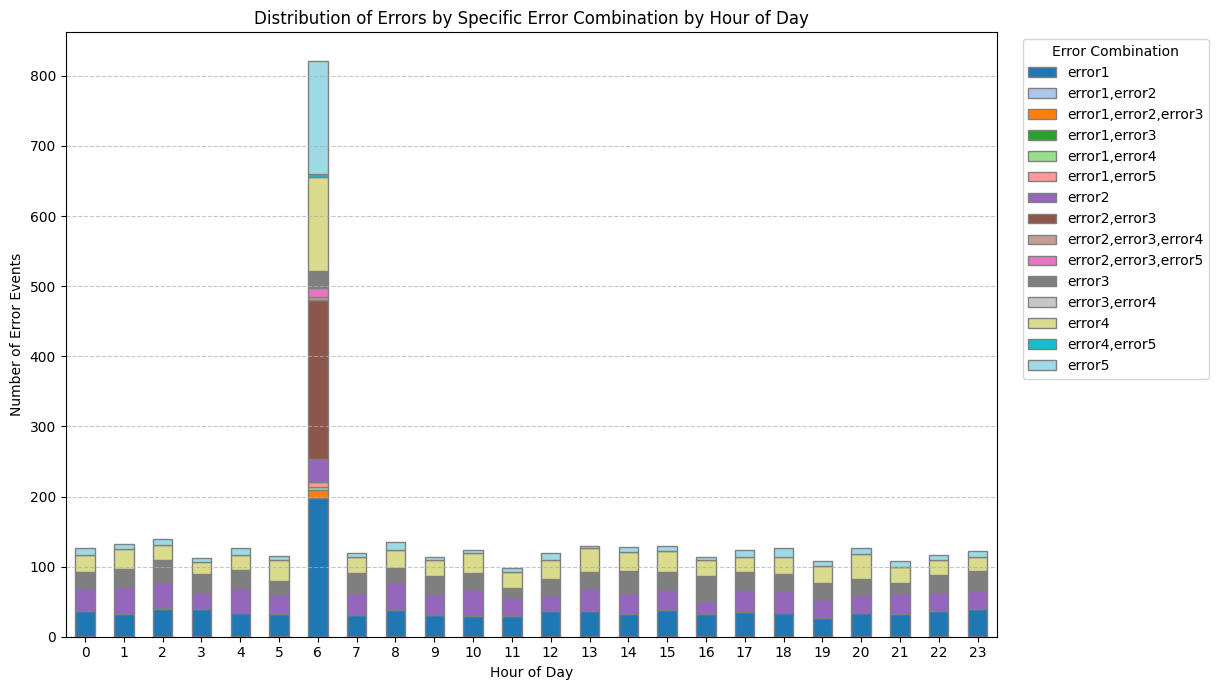

Saved error distribution by error combination by time of day: plots\event_errors_by_errorcombo_by_timeofday.png


In [9]:

def plot_errors_by_timeofday(df_pivoted, output_dir="plots"):
    """
    Plots the distribution of errors by hour of the day, stacked and colored
    by the combination of specific errors (error1-5) present.

    Parameters:
    -----------
    df_pivoted : pandas.DataFrame
        The curated pivoted DataFrame with 'datetime', 'isErrorEvent', 
        and error columns ('error1'-'error5').
    output_dir : str, optional
        Directory to save the plot, by default "plots".
    """
    # Check for base columns and identify error columns
    required_base = ['datetime', 'isErrorEvent']
    error_cols = [f'error{i}' for i in range(1, 6)]
    error_cols_present = [col for col in error_cols if col in df_pivoted.columns]

    if not error_cols_present:
        print("Error: No specific error columns (error1-5) found for grouping.")
        return

    required_cols = required_base + error_cols_present
    if not all(col in df_pivoted.columns for col in required_cols):
        print(f"Error: DataFrame must contain required columns for hourly plot: {required_cols}")
        return

    df = df_pivoted.copy()

    # Ensure datetime is in the correct format
    if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
        try:
            df['datetime'] = pd.to_datetime(df['datetime'])
        except Exception as e:
            print(f"Error converting 'datetime' column to datetime objects: {e}")
            return

    print(f"\nPlotting error distribution by specific error combination by time of day...")

    # Filter for rows where isErrorEvent is True
    df_errors = df[df['isErrorEvent'] == True].copy() # Use .copy() to avoid SettingWithCopyWarning

    if df_errors.empty:
        print("No error events found in the DataFrame.")
        return

    # Extract hour
    df_errors['hour'] = df_errors['datetime'].dt.hour

    # Create list_of_errors column for the error events
    def get_error_list(row):
        errors = [col for col in error_cols_present if isinstance(row[col], str) and row[col] != '' and pd.notna(row[col])]
        return ",".join(sorted(errors)) if errors else "Unknown Error Type" # Assign a label if no specific error ID found

    df_errors['list_of_errors'] = df_errors.apply(get_error_list, axis=1)

    # Group by hour and list_of_errors, count occurrences
    hourly_counts = df_errors.groupby(['hour', 'list_of_errors']).size().unstack(fill_value=0)

    # Ensure all hours 0-23 are present
    hourly_counts = hourly_counts.reindex(range(24), fill_value=0)

    # Filter out error combinations that have zero counts across all hours
    hourly_counts = hourly_counts.loc[:, (hourly_counts.sum(axis=0) > 0)]

    if hourly_counts.empty:
        print("No non-zero error counts found after grouping by error combination and hour.")
        return

    # Define colors for error combinations (using a colormap for potentially many combos)
    unique_error_combos = sorted(hourly_counts.columns)
    # Use a colormap like tab20 or similar
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_error_combos)))
    error_combo_color_map = dict(zip(unique_error_combos, colors))
    # Special color for "Unknown Error Type" if it exists
    if "Unknown Error Type" in error_combo_color_map:
        error_combo_color_map["Unknown Error Type"] = '#cccccc' # Light grey

    plot_colors = [error_combo_color_map.get(col) for col in hourly_counts.columns]

    # Create the stacked bar plot
    fig, ax = plt.subplots(figsize=(14, 7))

    hourly_counts.plot(kind='bar', stacked=True, ax=ax, color=plot_colors, edgecolor='grey')

    # Set labels and title
    ax.set_title('Distribution of Errors by Specific Error Combination by Hour of Day')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Number of Error Events') # Changed label
    ax.set_xticks(range(24))
    ax.set_xticklabels(range(24))
    # Limit legend entries if too many combinations
    max_legend_entries = 20
    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > max_legend_entries:
        # Display only the top N most frequent combinations in the legend
        top_combos = hourly_counts.sum().nlargest(max_legend_entries).index
        handles_labels_to_show = {label: handle for handle, label in zip(handles, labels) if label in top_combos}
        ax.legend(handles_labels_to_show.values(), handles_labels_to_show.keys(), title=f'Error Combinations (Top {max_legend_entries})', bbox_to_anchor=(1.02, 1), loc='upper left')
    else:
        ax.legend(title='Error Combination', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=0)

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    # Update filename to reflect the new grouping
    plot_filename = os.path.join(output_dir, "event_errors_by_errorcombo_by_timeofday.png")

    try:
        # Adjust layout to prevent legend overlap
        plt.tight_layout(rect=[0, 0, 0.88, 1]) # Make space for legend
        plt.savefig(plot_filename)
        plt.show()
        print(f"Saved error distribution by error combination by time of day: {plot_filename}")
    except Exception as e:
        print(f"\nError saving plot: {e}")
    finally:
        plt.close(fig)

plot_errors_by_timeofday(curated_events, output_dir='plots')


Plotting daily event histogram for Machine ID: 1...


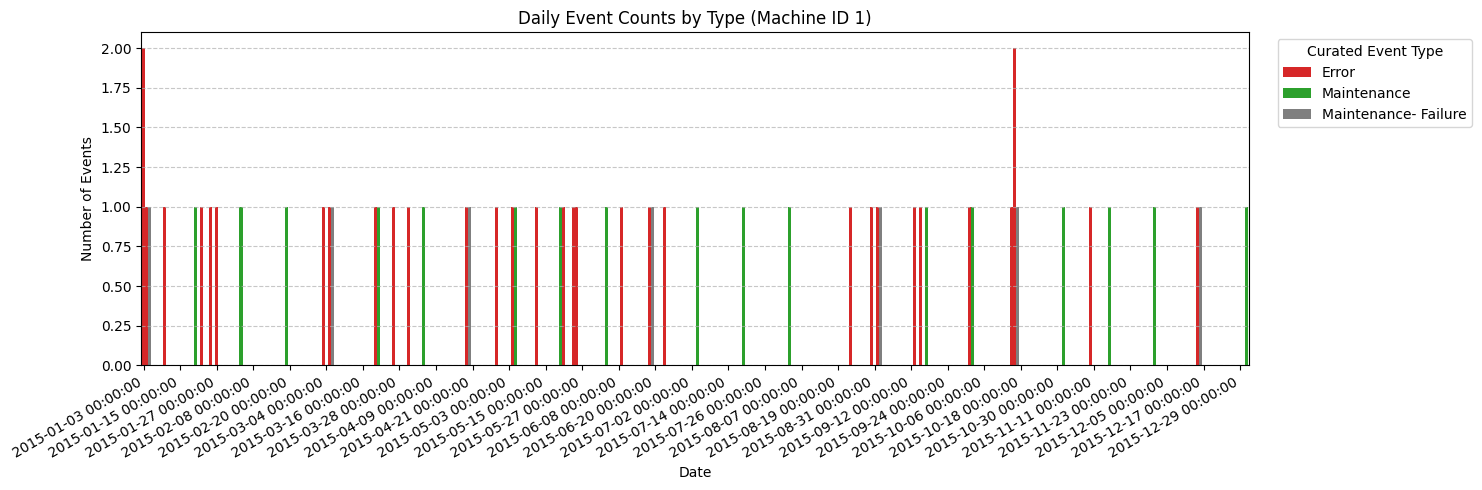

Saved daily event histogram plot: plots\event_daily_histogram_curated_machine_1.png


In [10]:

def plot_daily_event_histogram(curated_pivoted_df, machine_id=None, output_dir="plots"):
    """
    Plots a histogram of event counts per day, stacked and colored by CuratedEventType.
    Can optionally filter for a specific machine ID.

    Parameters:
    -----------
    curated_pivoted_df : pandas.DataFrame
        DataFrame output from curate_pivoted_events, containing at least 'datetime',
        'machineID', and 'CuratedEventType'.
    machine_id : int, optional
        If provided, filters the data for this specific machine ID. 
        If None (default), plots data for all machines.
    output_dir : str, optional
        Directory to save the plot, by default "plots".
    """
    required_cols = ['datetime', 'machineID', 'CuratedEventType']
    if not all(col in curated_pivoted_df.columns for col in required_cols):
        print(f"Error: Input DataFrame missing one or more required columns for daily histogram: {required_cols}")
        return

    df_plot = curated_pivoted_df.copy()
    plot_title = "Daily Event Counts by Type (All Machines)"
    filename_suffix = "all_machines"

    if machine_id is not None:
        df_plot = df_plot[df_plot['machineID'] == machine_id]
        plot_title = f"Daily Event Counts by Type (Machine ID {machine_id})"
        filename_suffix = f"machine_{machine_id}"

    if df_plot.empty:
        print(f"No event data found for the specified scope (Machine ID: {machine_id}) to plot daily histogram.")
        return

    # Ensure datetime is in the correct format
    if not pd.api.types.is_datetime64_any_dtype(df_plot['datetime']):
        try:
            df_plot['datetime'] = pd.to_datetime(df_plot['datetime'])
        except Exception as e:
            print(f"Error converting 'datetime' column to datetime objects: {e}")
            return

    print(f"\nPlotting daily event histogram for Machine ID: {machine_id if machine_id else 'All'}...")

    # Group by day and the new CuratedEventType
    daily_counts = df_plot.groupby([pd.Grouper(key='datetime', freq='D'), 'CuratedEventType']).size()

    # Unstack eventType to columns
    daily_counts_unstacked = daily_counts.unstack(level='CuratedEventType', fill_value=0)

    # Ensure all days in the range are present
    if not daily_counts_unstacked.empty:
        min_date = daily_counts_unstacked.index.min()
        max_date = daily_counts_unstacked.index.max()
        full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')
        daily_counts_unstacked = daily_counts_unstacked.reindex(full_date_range, fill_value=0)
    else:
        print("No data to plot after grouping.")
        return

    # Define colors for CuratedEventType values
    curated_event_type_colors = {
        'Error': '#d62728',
        'Maintenance': '#2ca02c',
        'Failure': '#ff7f0e',
        'Maintenance-Error': '#9467bd',
        'Maintenance-Failure': '#8c564b',
        'Error-Failure': '#e377c2',
        'Maintenance-Error-Failure': '#7f7f7f'
    }
    default_color = '#7f7f7f' # Grey for unknown/other combinations

    # Get colors in the order of columns present
    plot_colors = [curated_event_type_colors.get(col, default_color) for col in daily_counts_unstacked.columns]

    # Create the stacked bar plot
    fig, ax = plt.subplots(figsize=(17, 5))
    daily_counts_unstacked.plot(kind='bar', stacked=True, ax=ax, color=plot_colors, width=1.0)

    # --- Finalize Plot ---
    ax.set_title(plot_title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Events")
    ax.legend(title='Curated Event Type', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Improve date formatting on x-axis
    # Show fewer ticks for daily data over a long period
    tick_frequency = max(1, len(daily_counts_unstacked) // 30) # Aim for ~30 ticks
    ax.set_xticks(ax.get_xticks()[::tick_frequency])
    fig.autofmt_xdate()

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    plot_filename = os.path.join(output_dir, f"event_daily_histogram_curated_{filename_suffix}.png")

    try:
        plt.tight_layout(rect=[0, 0, 0.88, 1]) # Adjust layout for legend
        plt.savefig(plot_filename)
        plt.show()
        print(f"Saved daily event histogram plot: {plot_filename}")
    except Exception as e:
        print(f"\nError saving daily event histogram plot: {e}")
    finally:
        plt.close(fig)

plot_daily_event_histogram(curated_pivoted_df=curated_events, machine_id=1)



In [ ]:

def plot_unplanned_failure_components(curated_pivoted_df, output_dir="plots"):
    """
    Plots a bar chart showing the frequency of different component combinations 
    involved in unplanned failure events.

    Parameters:
    -----------
    curated_pivoted_df : pandas.DataFrame
        DataFrame output from curate_pivoted_events, containing 'isFailureEvent',
        'isScheduled', and component columns ('comp1'-'comp4').
    output_dir : str, optional
        Directory to save the plot, by default "plots".
    """
    base_required = ['isFailureEvent', 'isScheduled']
    components = [f'comp{i}' for i in range(1, 5)]
    required_cols = base_required + components

    if not all(col in curated_pivoted_df.columns for col in required_cols):
        missing = [col for col in required_cols if col not in curated_pivoted_df.columns]
        print(f"Error: Input DataFrame missing required columns for unplanned failure plot: {missing}")
        return

    df = curated_pivoted_df.copy()

    # Filter for unplanned failures
    df_unplanned_failures = df[(df['isFailureEvent'] == True) & (df['isScheduled'] == False)].copy()

    if df_unplanned_failures.empty:
        print("No unplanned failure events found in the data.")
        return

    print(f"\nPlotting unplanned failure component combinations...")

    # Function to get the list of non-empty component columns for a row
    def get_failed_comps(row):
        # Check specifically for non-empty string values
        failed = [comp for comp in components if isinstance(row[comp], str) and row[comp] != '' and pd.notna(row[comp])]
        return ",".join(sorted(failed)) # Sort for consistency

    # Create the new column
    df_unplanned_failures['list_of_failure_components'] = df_unplanned_failures.apply(get_failed_comps, axis=1)

    # Calculate counts for each combination
    component_combo_counts = df_unplanned_failures['list_of_failure_components'].value_counts()

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 7))

    component_combo_counts.plot(kind='bar', ax=ax, rot=45, color='#ff7f0e') # Orange color

    # Add labels and title
    ax.set_title("Frequency of Component Combinations in Unplanned Failures")
    ax.set_xlabel("Failed Component Combination")
    ax.set_ylabel("Number of Unplanned Failure Events")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add count labels on top of bars
    for container in ax.containers:
        ax.bar_label(container)

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    plot_filename = os.path.join(output_dir, f"event_unplanned_failure_component_combos.png")

    try:
        plt.tight_layout()
        plt.savefig(plot_filename)
        plt.show()
        print(f"Saved unplanned failure component combination plot: {plot_filename}")
    except Exception as e:
        print(f"\nError saving unplanned failure plot: {e}")
    finally:
        plt.close(fig)

plot_unplanned_failure_components(curated_events, output_dir='plots')


Plotting component maintenance preceded by errors (including double error 2&3) for All Machines...


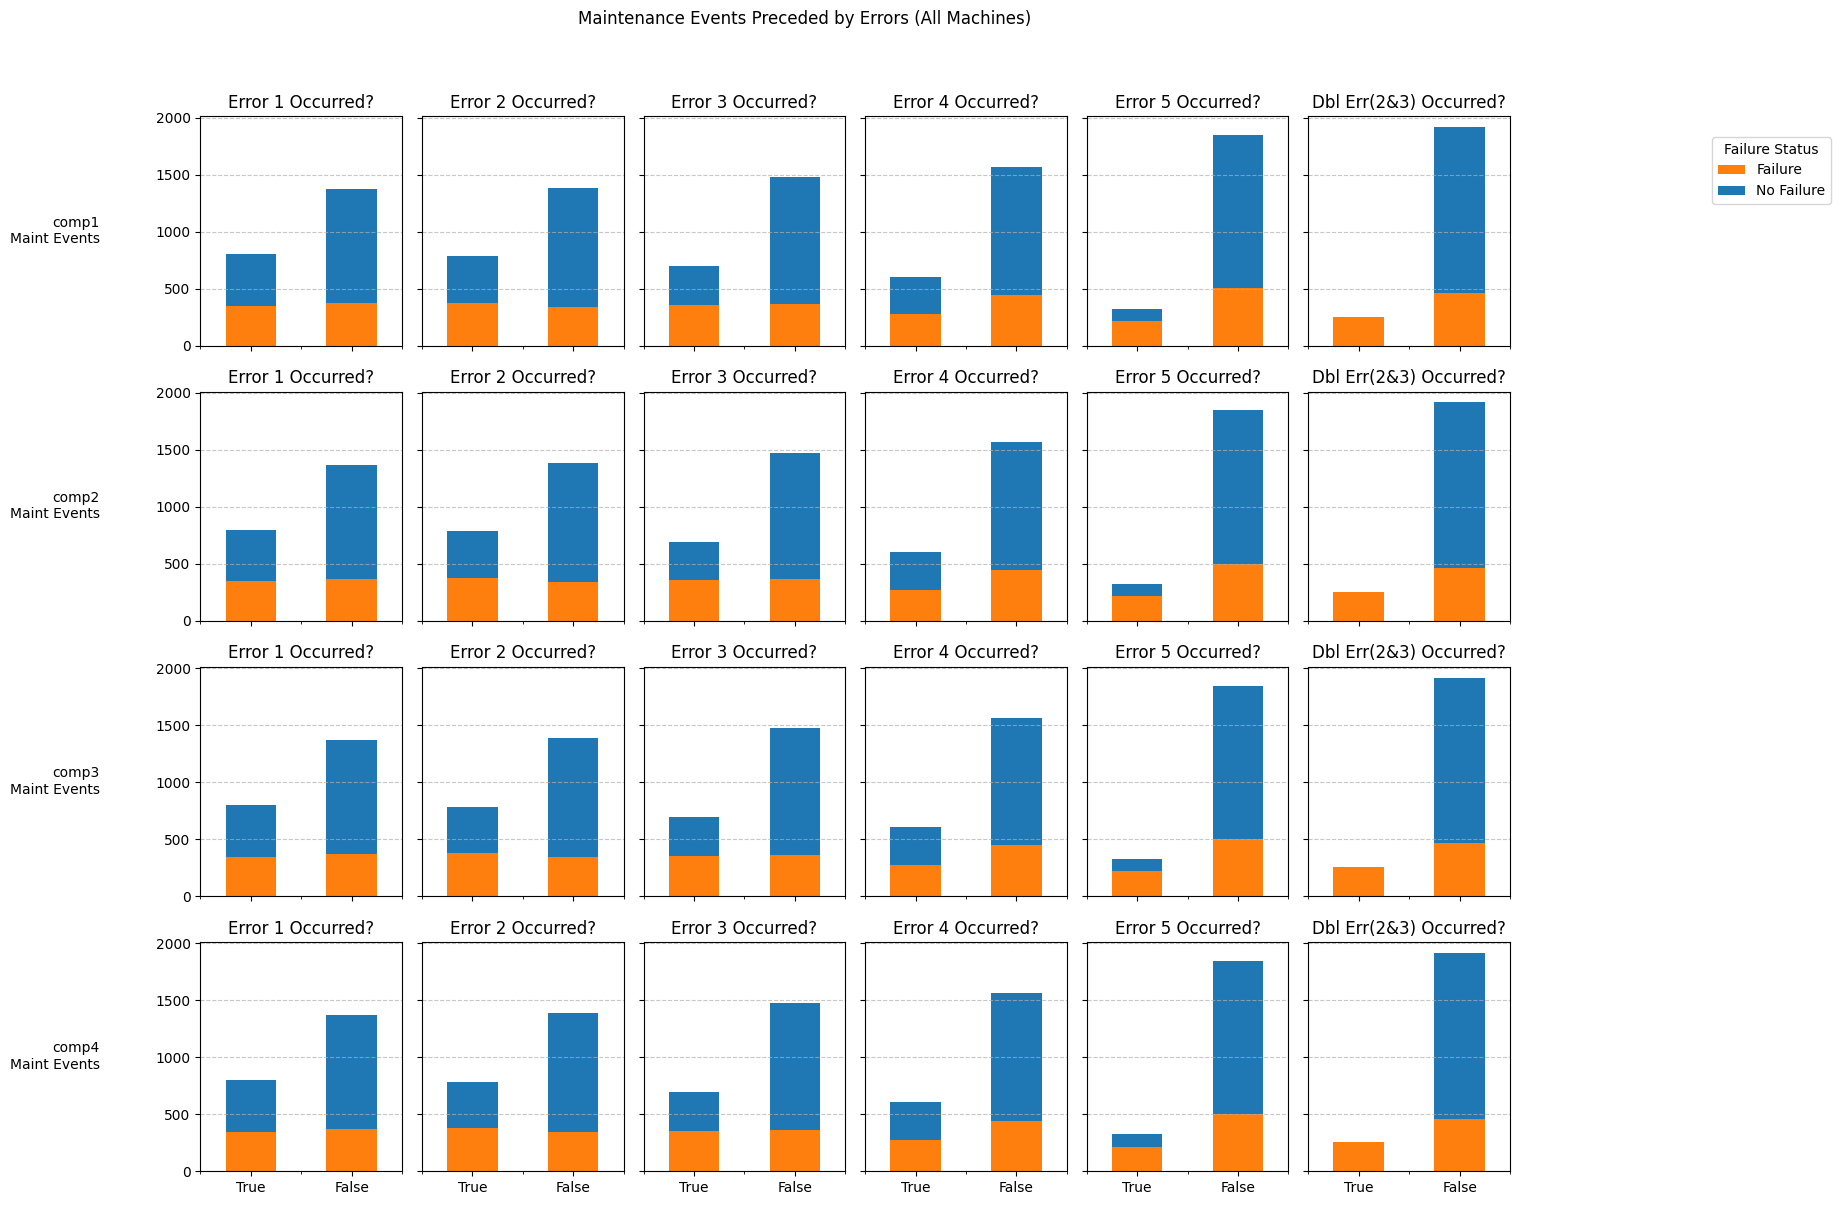

Saved maintenance preceded by errors plot: plots\event_maint_by_comp_preceded_by_errors_incl_double_all_machines.png


In [12]:

def plot_maintenance_by_recent_errors(curated_pivoted_df, machine_id=None, output_dir="plots"):
    """
    Plots a grid of bar charts comparing maintenance events for each component (1-4)
    preceded by specific errors (1-5) vs. those not, for a given machine.
    Color within bars indicates if the maintenance event was a failure.

    Parameters:
    -----------
    curated_pivoted_df : pandas.DataFrame
        DataFrame output from track_error_history, containing 'machineID',
        'isMaintenanceEvent', 'comp1'- 'comp4', and 'CountOfErrorXSinceLastMaintenance' cols.
    machine_id : int, optional
        The ID of the machine to plot. If None, plots for all machines.
    output_dir : str, optional
        Directory to save the plot, by default "plots".
    """
    # Determine scope: single machine or all
    if machine_id is not None:
        df_scope = curated_pivoted_df[curated_pivoted_df['machineID'] == machine_id].copy()
        scope_label = f"Machine ID: {machine_id}"
        filename_suffix = f"machine_{machine_id}"
        if df_scope.empty:
            print(f"No data found for machine {machine_id}.")
            return
    else:
        df_scope = curated_pivoted_df.copy()
        scope_label = "All Machines"
        filename_suffix = "all_machines"

    base_required = ['machineID', 'isMaintenanceEvent']
    if not all(col in df_scope.columns for col in base_required):
        print(f"Error: Input DataFrame missing base required columns: {base_required}")
        return

    components = [f'comp{i}' for i in range(1, 5)]
    if not all(comp in df_scope.columns for comp in components):
        missing_comps = [c for c in components if c not in df_scope.columns]
        print(f"Error: Input DataFrame missing required component columns: {missing_comps}")
        return

    print(f"\nPlotting component maintenance preceded by errors (including double error 2&3) for {scope_label}...")

    # Prepare subplots (4 rows for components, 6 columns for errors 1-5 + double error)
    fig, axes = plt.subplots(4, 6, figsize=(18, 12), sharey=True, sharex=True) # Changed figsize and grid size

    fig.suptitle(f"Maintenance Events Preceded by Errors ({scope_label})", y=1.0)

    # Check if the double error count column exists
    double_error_count_col = 'CountOfDoubleErrorsSinceLastMaintenance'
    has_double_error_col = double_error_count_col in df_scope.columns
    if not has_double_error_col:
        print(f"Warning: Column '{double_error_count_col}' not found. Skipping double error plot.")

    for comp_idx, comp_name in enumerate(components):
        # Filter for maintenance events involving the current component for the current scope
        df_maint_comp = df_scope[(df_scope['isMaintenanceEvent'] == True) & (df_scope[comp_name] != '')].copy()

        if df_maint_comp.empty:
            print(f"No maintenance events involving {comp_name} found for {scope_label}. Skipping row.")
            # Optionally hide the row or display a message
            for plot_col_idx in range(6): # Updated range to 6
                axes[comp_idx, plot_col_idx].set_visible(False)
            axes[comp_idx, 0].set_ylabel(f"{comp_name}\n(No Data)", rotation=0, labelpad=40, ha='right', va='center')
            continue

        # Create temporary boolean columns for this component's maintenance subset
        error_check_cols_present = {}
        # Individual errors 1-5
        for i in range(1, 6):
            count_col = f'CountOfError{i}SinceLastMaintenance'
            has_error_col = f'_hasError{i}Occured'
            if count_col in df_maint_comp.columns:
                df_maint_comp[has_error_col] = (df_maint_comp[count_col] > 0).fillna(False)
                error_check_cols_present[i] = has_error_col
            else:
                error_check_cols_present[i] = None
        # Double error
        has_double_error_check_col = f'_hasDoubleErrorOccured'
        if has_double_error_check_col:
            df_maint_comp[has_double_error_check_col] = (df_maint_comp[double_error_count_col] > 0).fillna(False)
            error_check_cols_present['double'] = has_double_error_check_col
        else:
             error_check_cols_present['double'] = None

        # Loop through error types (1-5) and the double error
        for plot_col_idx, error_key in enumerate(list(range(1, 6)) + ['double']):
            ax = axes[comp_idx, plot_col_idx]
            check_col = error_check_cols_present.get(error_key)
            
            if check_col:
                # Group by whether the error occurred AND failure status
                counts = df_maint_comp.groupby([check_col, 'isFailureEvent']).size()
                # Unstack to get Failure status as columns
                counts_unstacked = counts.unstack(level='isFailureEvent', fill_value=0)
                # Ensure both error statuses (True/False) and failure statuses (True/False) are present
                counts_unstacked = counts_unstacked.reindex(index=[True, False], fill_value=0)
                counts_unstacked = counts_unstacked.reindex(columns=[True, False], fill_value=0)
                # Rename columns for clarity in legend
                counts_unstacked.columns = ['Failure', 'No Failure']

                # Plot stacked bar chart
                counts_unstacked[['Failure', 'No Failure']].plot(kind='bar', stacked=True, ax=ax, rot=0,
                                                                color=['#ff7f0e', '#1f77b4'])

                # Set title based on error type
                if isinstance(error_key, int):
                    ax.set_title(f"Error {error_key} Occurred?")
                else: # Double error
                    ax.set_title(f"Dbl Err(2&3) Occurred?")
                ax.set_xlabel("") # Keep x-label minimal
                ax.set_xticklabels(['True', 'False'])
                if plot_col_idx == 0:
                    # Add component name to Y label
                    ax.set_ylabel(f"{comp_name}\nMaint Events", rotation=0, labelpad=40, ha='right', va='center')
                # Add legend only once for the whole figure
                if comp_idx == 0 and plot_col_idx == 0:
                    handles, labels = ax.get_legend_handles_labels()
                    fig.legend(handles, labels, title='Failure Status', bbox_to_anchor=(1.0, 0.9), loc='upper left')
                ax.get_legend().remove() # Remove individual subplot legends
                ax.grid(axis='y', linestyle='--', alpha=0.7)
            else:
                # Handle case where CountOfErrorX or DoubleError column was missing
                if isinstance(error_key, int):
                     ax.set_title(f"Error {error_key}\n(No Data)")
                else:
                     ax.set_title(f"Dbl Err(2&3)\n(No Data)")
                ax.set_xticklabels([])
                ax.set_yticks([])

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    # Update filename slightly (optional)
    plot_filename = os.path.join(output_dir, f"event_maint_by_comp_preceded_by_errors_incl_double_{filename_suffix}.png")

    try:
        plt.tight_layout(rect=[0.05, 0, 0.9, 0.97]) # Adjust layout further for figure legend
        plt.savefig(plot_filename)
        plt.show()
        print(f"Saved maintenance preceded by errors plot: {plot_filename}")
    except Exception as e:
        print(f"\nError saving maintenance preceded by errors plot: {e}")
    finally:
        plt.close(fig)

plot_maintenance_by_recent_errors(curated_events, machine_id=None, output_dir='plots')

Error: Combined Events DataFrame missing one or more required columns: ['datetime', 'machineID', 'eventType', 'eventcategory']

Plotting telemetry and events for machine 1...


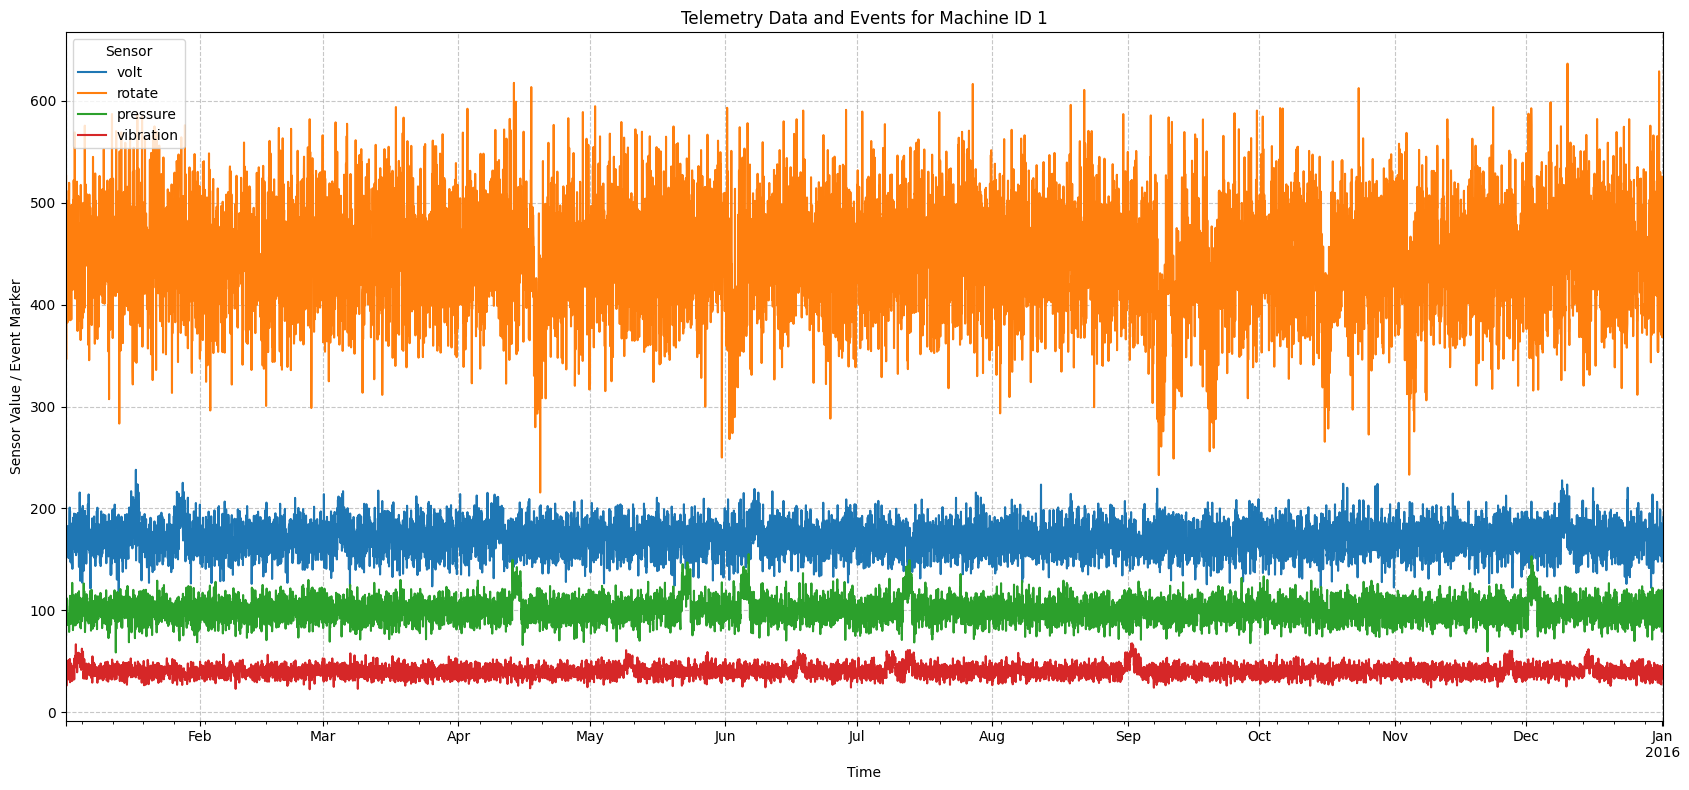

Saved telemetry and events plot: plots\telemetry_events_machine_1.png


In [13]:
def plot_single_machine_telemetry(df_telemetry, combined_events, machine_id, num_days=None, output_dir="plots"):
    """
    Creates a time series plot for a single machine showing telemetry data 
    (volt, rotate, pressure, vibration) and overlays events (errors, failures,
    maintenance) as vertical lines with text annotations.
    Can optionally filter to the first num_days of 2014.

    Parameters:
    -----------
    df_telemetry : pandas.DataFrame
        DataFrame containing telemetry data with 'datetime', 'machineID', 
        'volt', 'rotate', 'pressure', 'vibration'.
    combined_events : pandas.DataFrame
        DataFrame containing combined event data with 'datetime', 'machineID', 
        'eventType', 'eventcategory'.
    machine_id : int
        The ID of the machine to plot.
    num_days : int, optional
        If provided, plots only the first num_days starting from 2014-01-01.
        If None (default), plots all data with events filtered from 2015-01-01.
    output_dir : str, optional
        Directory to save the plot, by default "plots"
    """
    # --- Input Validation ---
    telemetry_required_cols = ['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration']
    if not all(col in df_telemetry.columns for col in telemetry_required_cols):
        print(f"Error: Telemetry DataFrame missing one or more required columns: {telemetry_required_cols}")
        return

    event_required_cols = ['datetime', 'machineID', 'eventType', 'eventcategory']
    if not all(col in combined_events.columns for col in event_required_cols):
        print(f"Error: Combined Events DataFrame missing one or more required columns: {event_required_cols}")
        # Proceeding without events if telemetry is valid
        plot_events = False
    else:
        plot_events = True

    # --- Filter Data by Machine ID ---
    machine_telemetry = df_telemetry[df_telemetry['machineID'] == machine_id].copy()
    if machine_telemetry.empty:
        print(f"Error: No telemetry data found for machineID {machine_id}.")
        return

    if plot_events:
        machine_events = combined_events[combined_events['machineID'] == machine_id].copy()
        # Ensure datetime is in the correct format before filtering
        machine_events['datetime'] = pd.to_datetime(machine_events['datetime'])
    else:
        machine_events = pd.DataFrame()

    # --- Apply Time Period Filter --- 
    plot_title = f"Telemetry Data and Events for Machine ID {machine_id}"
    filename_suffix = ""

    # Ensure telemetry datetime is correct type before filtering
    machine_telemetry['datetime'] = pd.to_datetime(machine_telemetry['datetime'])

    if num_days is not None:
        try:
            num_days = int(num_days)
            start_date = pd.Timestamp('2015-01-01')
            end_date = start_date + pd.Timedelta(days=num_days)
            
            print(f"Filtering data for machine {machine_id} to {start_date.date()} - {end_date.date()}")
            
            # Filter telemetry
            machine_telemetry = machine_telemetry[
                (machine_telemetry['datetime'] >= start_date) & 
                (machine_telemetry['datetime'] < end_date)
            ]
            
            # Filter events (if they exist)
            if plot_events:
                 machine_events = machine_events[
                    (machine_events['datetime'] >= start_date) & 
                    (machine_events['datetime'] < end_date)
                ]
            
            plot_title = f"Telemetry Data and Events for Machine ID {machine_id} (First {num_days} Days of 2014)"
            filename_suffix = f"_2014_first_{num_days}_days"

        except ValueError:
             print(f"Warning: Invalid value provided for num_days ('{num_days}'). Plotting full history instead.")
             # Apply default event filtering if num_days was invalid
             if plot_events:
                start_date_events = pd.Timestamp('2015-01-01')
                machine_events = machine_events[machine_events['datetime'] >= start_date_events]
                print(f"Filtered events for machine {machine_id} to on/after {start_date_events.date()}")
    else:
        # Default behavior: Filter events from 2015 onwards
        if plot_events:
            start_date_events = pd.Timestamp('2015-01-01')
            machine_events = machine_events[machine_events['datetime'] >= start_date_events]
            print(f"Filtered events for machine {machine_id} to on/after {start_date_events.date()}")
            
    # --- Filter out maintenance events (applied AFTER date range selection) --- 
    if plot_events:
        machine_events = machine_events[machine_events['eventType'] != 'maintenance']
        print(f"Filtered out maintenance events for machine {machine_id}.")
        machine_events['eventcategory'] = machine_events['eventcategory'].astype(str)

    # --- Prepare Telemetry for Plotting (after potential date filtering) ---
    if machine_telemetry.empty:
        print(f"Error: No telemetry data found for machineID {machine_id} in the specified period.")
        return
        
    machine_telemetry.set_index('datetime', inplace=True)
    telemetry_cols = ['volt', 'rotate', 'pressure', 'vibration']
    
    print(f"\nPlotting telemetry and events for machine {machine_id}...")
    
    # --- Create Plot ---
    fig, ax = plt.subplots(figsize=(17, 8))
    
    # Plot Telemetry Data
    machine_telemetry[telemetry_cols].plot(ax=ax, legend=True)
    
    # --- Plot Events ---
    if plot_events and not machine_events.empty:
        y_min, y_max = ax.get_ylim() # Get y-axis limits for text placement
        text_y_pos = y_max * 0.95 # Position text near the top
        
        for _, event in machine_events.iterrows():
            event_time = event['datetime']
            event_label = f"{event['eventType']}_{event['eventcategory']}"
            
            # Draw vertical line
            ax.axvline(x=event_time, color='black', linestyle='--', linewidth=1)
            
            # Add text annotation
            ax.text(x=event_time, y=text_y_pos, s=event_label, 
                    rotation=90, verticalalignment='top', 
                    fontsize=8, color='black', 
                    bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))

    # --- Finalize Plot ---
    ax.set_xlabel("Time")
    ax.set_ylabel("Sensor Value / Event Marker")
    ax.set_title(plot_title) # Use dynamic title
    ax.legend(title='Sensor', loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.7)

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    # Update filename based on filtering
    plot_filename = os.path.join(output_dir, f"telemetry_events_machine_{machine_id}{filename_suffix}.png") 
    
    plt.tight_layout()
    plt.savefig(plot_filename)
    plt.show()
    plt.close(fig) 
    print(f"Saved telemetry and events plot: {plot_filename}")

plot_single_machine_telemetry(curated_telemetry, curated_events, machine_id=1, num_days=None)


Detrending telemetry signals...
Detrended volt. Mean=-1.5618405206836802e-16 std=15.50438334168729
Detrended rotate. Mean=1.7556552718644695e-15 std=52.60857765598528
Detrended pressure. Mean=-4.635569306592074e-16 std=11.030799904160752
Detrended vibration. Mean=7.659345837041502e-18 std=5.371903909120991

Generating periodograms for machine 1...


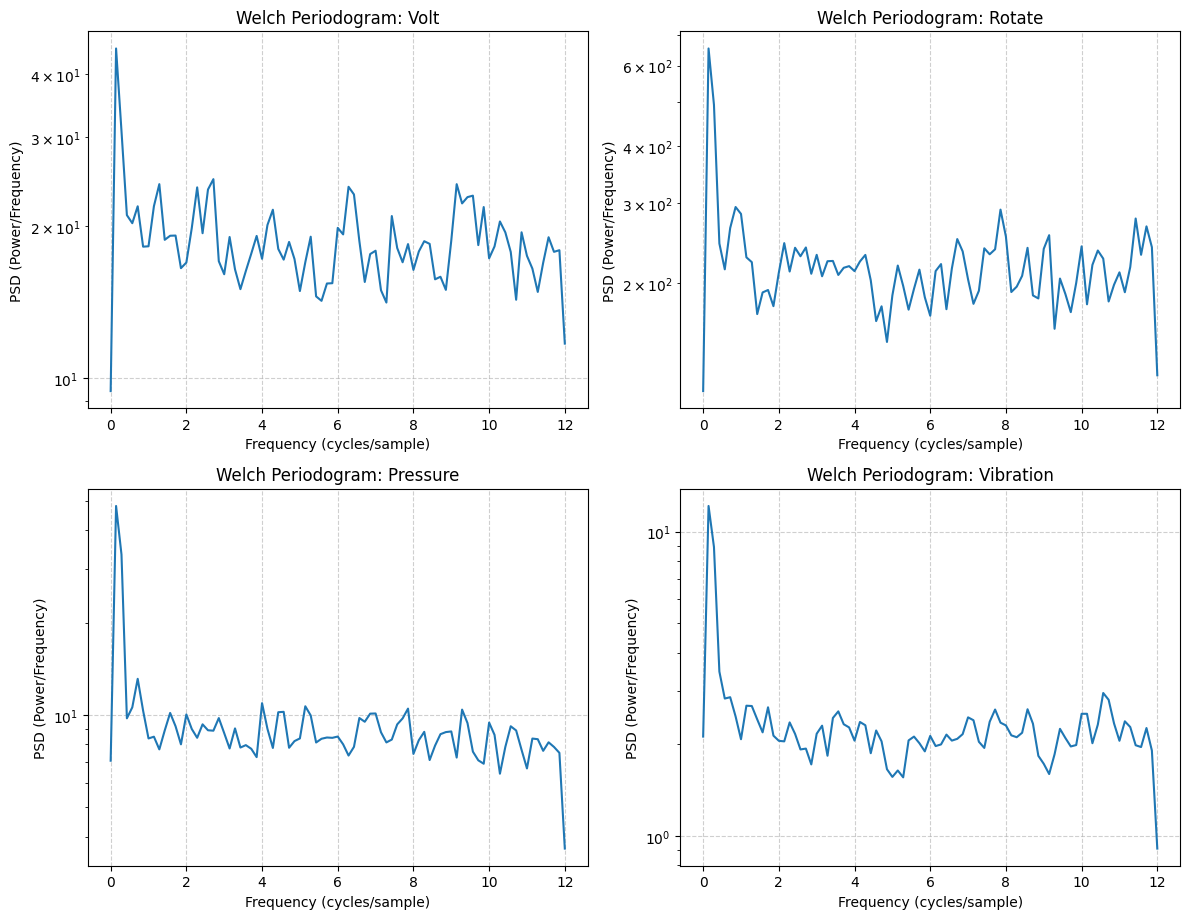

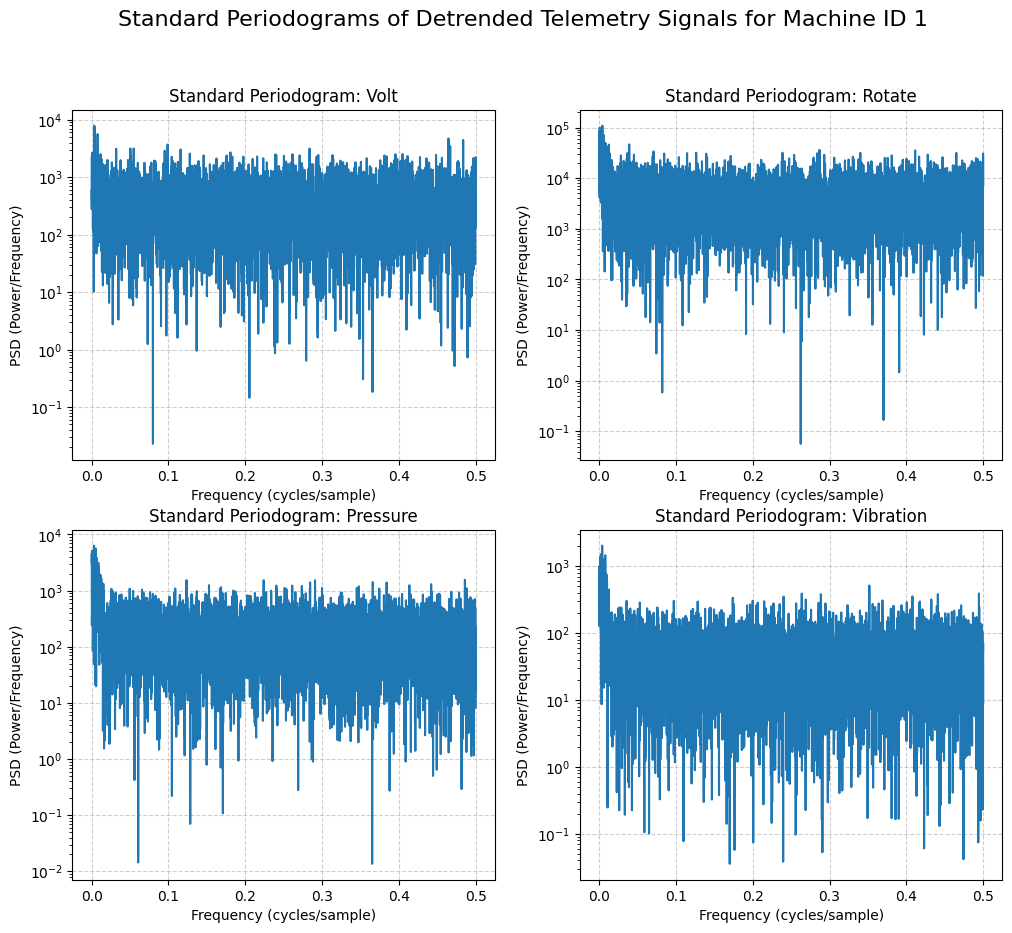

Saved standard periodogram plot: plots\telemetry_periodogram_machine_1.png


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Saved Welch periodogram plot: plots\telemetry_welch_periodogram_machine_1.png


<Figure size 640x480 with 0 Axes>

In [14]:
def _detrend_telemetry(df_telemetry):
    """
    Detrends the telemetry signal columns ('volt', 'rotate', 'pressure', 'vibration')
    in the input DataFrame.

    Parameters:
    -----------
    df_telemetry : pandas.DataFrame
        DataFrame containing telemetry data with required columns.

    Returns:
    --------
    pandas.DataFrame
        A new DataFrame with detrended telemetry columns. Original columns
        are kept if detrending fails for a specific column.
    """
    required_cols = ['volt', 'rotate', 'pressure', 'vibration']
    if not all(col in df_telemetry.columns for col in required_cols):
        print(f"Error: Detrending requires columns: {required_cols}. Skipping.")
        return df_telemetry.copy() # Return original if columns missing

    df_detrended = df_telemetry.copy()
    
    print("\nDetrending telemetry signals...")

    for col in required_cols:
        signal_data = df_detrended[col].values
        
        # Check for NaNs or constant signals before detrending
        if np.isnan(signal_data).all():
             print(f"Skipping detrending for {col}: all values are NaN.")
             continue
        if len(np.unique(signal_data[~np.isnan(signal_data)])) <= 1:
             print(f"Skipping detrending for {col}: signal is constant (or NaN).")
             continue
             
        try:
            # Handle potential NaNs by detrending only non-NaN parts if necessary,
            # though scipy.signal.detrend might handle internal NaNs depending on version.
            # A simple approach: detrend and assign back, assuming detrend handles it.
            # More robust: interpolate NaNs before detrending.
            detrended = signal.detrend(signal_data)
            df_detrended[col] = detrended - detrended.mean()
            print(f"Detrended {col}. Mean={df_detrended[col].mean()} std={df_detrended[col].std()}")
        except ValueError as e:
            print(f"Could not detrend signal {col}. Keeping original. Error: {e}")
            # Keep original column if detrending fails
        

    return df_detrended

def plot_detrended_periodogram(df_telemetry, machine_id, output_dir="plots"):
    """
    Detrends telemetry signals for a specific machine and plots their periodograms
    (standard and Welch method).

    Parameters:
    -----------
    df_telemetry : pandas.DataFrame
        DataFrame containing telemetry data with 'datetime', 'machineID', 
        'volt', 'rotate', 'pressure', 'vibration'.
    machine_id : int
        The ID of the machine to analyze.
    output_dir : str, optional
        Directory to save the plot, by default "plots".
    """
    df_telemetry = _detrend_telemetry(df_telemetry)

    required_cols = ['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration']
    if not all(col in df_telemetry.columns for col in required_cols):
        print(f"Error: Telemetry DataFrame missing one or more required columns: {required_cols}")
        return

    # Filter for the specific machine and sort by time
    machine_data = df_telemetry[df_telemetry['machineID'] == machine_id].copy()
    machine_data['datetime'] = pd.to_datetime(machine_data['datetime'])
    machine_data.sort_values(by='datetime', inplace=True)

    if machine_data.empty:
        print(f"Error: No telemetry data found for machineID {machine_id}.")
        return
        
    # Check for NaNs - detrend/periodogram might fail or give misleading results
    if machine_data[['volt', 'rotate', 'pressure', 'vibration']].isnull().values.any():
        print(f"Warning: NaN values found in telemetry data for machine {machine_id}. Consider imputation before analysis.")
        # Option: Fill NaNs, e.g., machine_data.fillna(method='ffill', inplace=True) or drop them
        # For now, we proceed but results might be affected.
        
    print(f"\nGenerating periodograms for machine {machine_id}...")

    telemetry_cols = ['volt', 'rotate', 'pressure', 'vibration']
    # Assume sampling frequency is 1 (per record/hour). Adjust if known otherwise.
    fs = 1 

    # --- Standard Periodogram Plot ---
    fig_std, axes_std = plt.subplots(2, 2, figsize=(12, 10))
    axes_std = axes_std.flatten() # Flatten the 2x2 array for easy iteration

    # --- Welch Periodogram Plot ---
    fig_welch, axes_welch = plt.subplots(2, 2, figsize=(12, 10))
    axes_welch = axes_welch.flatten()

    all_signals_processed_std = True
    all_signals_processed_welch = True

    for i, col in enumerate(telemetry_cols):
        ax_std = axes_std[i]
        ax_welch = axes_welch[i]
        signal_data = machine_data[col].values
        
        # Detrend the signal
        try:
            detrended_signal = signal.detrend(signal_data)

            # --- Standard Periodogram ---
            try:
                f_std, Pxx_std = signal.periodogram(detrended_signal, fs=fs, detrend='constant')
                # Skip the zero-frequency component (f[0])
                f_std_plot = f_std[1:]
                Pxx_std_plot = Pxx_std[1:]
                
                # Plot periodogram (Power Spectral Density)
                ax_std.semilogy(f_std_plot, Pxx_std_plot) # Use log scale for power
                ax_std.set_title(f"Standard Periodogram: {col.capitalize()}")
                ax_std.set_xlabel("Frequency (cycles/sample)")
                ax_std.set_ylabel("PSD (Power/Frequency)")
                ax_std.grid(True, linestyle='--', alpha=0.6)
                # ax_std.set_xlim([0, fs / 2]) # Optionally limit x-axis
            except ValueError as e_std:
                print(f"Could not calculate standard periodogram for {col}, machine {machine_id}. Error: {e_std}")
                ax_std.set_title(f"Standard Periodogram: {col.capitalize()} (Error)")
                ax_std.text(0.5, 0.5, "Error during processing", horizontalalignment='center', verticalalignment='center', transform=ax_std.transAxes)
                all_signals_processed_std = False
            
            # --- Welch Periodogram ---
            try:
                f_welch, Pxx_welch = signal.welch(
                    detrended_signal,
                    fs=24,              # 24 samples per day
                    detrend='constant',
                    window='hann',
                    nperseg=24*7,       # e.g. 1‑week segments for smoother low‑freq resolution
                    noverlap=0
                )
                # Skip the zero-frequency component (f[0])
                f_welch_plot = f_welch[1:]
                Pxx_welch_plot = Pxx_welch[1:]

                # Plot Welch periodogram (Power Spectral Density)
                ax_welch.semilogy(f_welch, Pxx_welch) # Use log scale for power
                ax_welch.set_title(f"Welch Periodogram: {col.capitalize()}")
                ax_welch.set_xlabel("Frequency (cycles/sample)")
                ax_welch.set_ylabel("PSD (Power/Frequency)")
                ax_welch.grid(True, linestyle='--', alpha=0.6)
                # ax_welch.set_xlim([0, fs / 2]) # Optionally limit x-axis
            except ValueError as e_welch:
                print(f"Could not calculate Welch periodogram for {col}, machine {machine_id}. Error: {e_welch}")
                ax_welch.set_title(f"Welch Periodogram: {col.capitalize()} (Error)")
                ax_welch.text(0.5, 0.5, "Error during processing", horizontalalignment='center', verticalalignment='center', transform=ax_welch.transAxes)
                all_signals_processed_welch = False

        except ValueError as e_detrend:
             print(f"Could not detrend signal {col} for machine {machine_id}. Skipping periodograms. Error: {e_detrend}")
             # Mark both plots as error for this signal
             ax_std.set_title(f"Standard Periodogram: {col.capitalize()} (Detrend Error)")
             ax_std.text(0.5, 0.5, "Error during detrending", ha='center', va='center', transform=ax_std.transAxes)
             ax_welch.set_title(f"Welch Periodogram: {col.capitalize()} (Detrend Error)")
             ax_welch.text(0.5, 0.5, "Error during detrending", ha='center', va='center', transform=ax_welch.transAxes)
             all_signals_processed_std = False
             all_signals_processed_welch = False

    # --- Finalize and Save Standard Periodogram Plot ---
    if all_signals_processed_std:
        fig_std.suptitle(f"Standard Periodograms of Detrended Telemetry Signals for Machine ID {machine_id}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout
        # Ensure output directory exists
        os.makedirs(output_dir, exist_ok=True)
        plot_filename_std = os.path.join(output_dir, f"telemetry_periodogram_machine_{machine_id}.png")
        plt.figure(fig_std.number) # Ensure we save the correct figure
        plt.show()
        plt.savefig(plot_filename_std)
        print(f"Saved standard periodogram plot: {plot_filename_std}")
    else:
        print(f"Standard periodogram plot not saved due to processing errors for machine {machine_id}.")
    plt.close(fig_std)

    # --- Finalize and Save Welch Periodogram Plot ---
    if all_signals_processed_welch:
        fig_welch.suptitle(f"Welch Periodograms of Detrended Telemetry Signals for Machine ID {machine_id}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout
        # Ensure output directory exists
        os.makedirs(output_dir, exist_ok=True)
        plot_filename_welch = os.path.join(output_dir, f"telemetry_welch_periodogram_machine_{machine_id}.png")
        plt.figure(fig_welch.number) # Ensure we save the correct figure
        plt.show()
        plt.savefig(plot_filename_welch)
        print(f"Saved Welch periodogram plot: {plot_filename_welch}")
    else:
         print(f"Welch periodogram plot not saved due to processing errors for machine {machine_id}.")
    plt.close(fig_welch)

plot_detrended_periodogram(curated_telemetry, machine_id=1)

In [ ]:

def plot_wavelet_transform(df_telemetry, machine_id, output_dir="plots", wavelet_name='morl', max_scale=64):
    """
    Performs Continuous Wavelet Transform (CWT) on telemetry signals for a specific
    machine and plots the scalograms (magnitude of CWT coefficients).

    Requires the 'PyWavelets' library (pip install PyWavelets).
    Requires 'numpy' and 'matplotlib'.

    Parameters:
    -----------
    df_telemetry : pandas.DataFrame
        DataFrame containing telemetry data with 'datetime', 'machineID',
        'volt', 'rotate', 'pressure', 'vibration'.
    machine_id : int
        The ID of the machine to analyze.
    output_dir : str, optional
        Directory to save the plot, by default "plots".
    wavelet_name : str, optional
        Name of the wavelet to use (e.g., 'morl', 'cmor', 'gaus1'), by default 'morl'.
    max_scale : int, optional
        Maximum scale to use for the CWT analysis, by default 64.
        Higher scales correspond to lower frequencies.
    """
    # Local imports to make the function self-contained if needed, though top-level is preferred.

    required_cols = ['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration']
    if not all(col in df_telemetry.columns for col in required_cols):
        print(f"Error: Telemetry DataFrame missing one or more required columns: {required_cols}")
        return

    # Filter for the specific machine and sort by time
    machine_data = df_telemetry[df_telemetry['machineID'] == machine_id].copy()
    # Ensure datetime column is in right format if not already
    if not pd.api.types.is_datetime64_any_dtype(machine_data['datetime']):
        machine_data['datetime'] = pd.to_datetime(machine_data['datetime'])
    machine_data.sort_values(by='datetime', inplace=True)

    if machine_data.empty:
        print(f"Error: No telemetry data found for machineID {machine_id}.")
        return

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    telemetry_cols = ['volt', 'rotate', 'pressure', 'vibration']
    # Define scales for CWT. A simple range from 1 to max_scale.
    scales = np.arange(1, max_scale + 1)
    # Assuming data is hourly, sampling period dt = 1 hour.
    dt = 1

    print(f"\nGenerating CWT scalograms for machine {machine_id} using '{wavelet_name}' wavelet...")

    fig, axes = plt.subplots(len(telemetry_cols), 1, figsize=(15, 4 * len(telemetry_cols)), sharex=True)
    if len(telemetry_cols) == 1:
        axes = [axes] # Ensure axes is iterable even for one plot

    time_index = machine_data['datetime'] # For x-axis
    time_num = np.arange(len(time_index)) # Numerical time for extent

    all_signals_processed = True

    for i, col in enumerate(telemetry_cols):
        ax = axes[i]
        signal_data = machine_data[col].values

        # Check for NaNs - CWT typically requires continuous data
        if np.isnan(signal_data).any():
            print(f"Warning: NaN values found in {col} for machine {machine_id}. CWT might produce unexpected results or fail. Consider imputation.")
            # Optional: Interpolate NaNs
            # signal_data = pd.Series(signal_data).interpolate().values
            # Check again if interpolation left NaNs (e.g., at edges)
            if np.isnan(signal_data).any():
                 print(f"Error: NaN values still present in {col} after potential handling. Skipping CWT.")
                 ax.set_title(f"{col.capitalize()} - NaN Values Present")
                 ax.text(0.5, 0.5, "NaN values prevent CWT", ha='center', va='center', transform=ax.transAxes)
                 all_signals_processed = False
                 continue

        if len(signal_data) < max(scales): # Check if signal is long enough for chosen scales
            print(f"Warning: Signal length ({len(signal_data)}) for {col} is shorter than max scale ({max(scales)}). Reducing max scale.")
            current_max_scale = len(signal_data) - 1
            if current_max_scale < 1:
                 print(f"Error: Signal {col} too short for CWT. Skipping.")
                 ax.set_title(f"{col.capitalize()} - Signal Too Short for CWT")
                 ax.text(0.5, 0.5, "Signal too short", ha='center', va='center', transform=ax.transAxes)
                 all_signals_processed = False
                 continue
            current_scales = np.arange(1, current_max_scale + 1)
        else:
            current_scales = scales

        try:
            # Perform CWT
            coefficients, frequencies = pywt.cwt(signal_data, current_scales, wavelet_name, sampling_period=dt)

            # Calculate periods corresponding to frequencies (in hours)
            # Avoid division by zero
            valid_freq_mask = frequencies > 1e-9 # Check for non-zero frequencies
            periods = np.full_like(frequencies, np.nan)
            periods[valid_freq_mask] = 1 / frequencies[valid_freq_mask]

            # Plot the scalogram (magnitude of coefficients)
            # Use periods for the y-axis, time for the x-axis
            # extent defines the x and y ranges: [left, right, bottom, top]
            # Need finite periods for extent
            valid_period_mask = np.isfinite(periods)
            if not np.any(valid_period_mask):
                 print(f"Error: No valid periods calculated for {col}. Skipping plot.")
                 ax.set_title(f"{col.capitalize()} - Period Calculation Error")
                 all_signals_processed = False
                 continue
            
            # Log scale for periods often makes sense
            # Use min/max of valid periods for y-axis limits
            # Flip y-axis so low frequency (large period) is at the bottom
            im = ax.imshow(np.abs(coefficients), cmap='viridis', aspect='auto',
                           extent=[time_num[0], time_num[-1], periods[valid_period_mask].max(), periods[valid_period_mask].min()])

            ax.set_title(f"Wavelet Scalogram: {col.capitalize()}")
            ax.set_ylabel("Period (hours)")

            # Configure y-axis ticks and labels
            y_min_lim, y_max_lim = periods[valid_period_mask].min(), periods[valid_period_mask].max()
            ax.set_ylim(y_max_lim, y_min_lim) # Flipped y-axis

            if periods[valid_period_mask].max() / periods[valid_period_mask].min() > 10:
                ax.set_yscale('log')
                # Use LogLocator for automatic log ticks
                from matplotlib.ticker import LogLocator, NullFormatter, ScalarFormatter, NullLocator
                # Set major ticks for powers of 2 or 10, or automatically
                ax.yaxis.set_major_locator(LogLocator(base=2, numticks=10))
                ax.yaxis.set_major_formatter(ScalarFormatter()) # Use standard number format
                # Remove minor ticks by setting locator to NullLocator
                ax.yaxis.set_minor_locator(NullLocator())
            else:
                 # Linear scale: Define a reasonable number of ticks
                 from matplotlib.ticker import MaxNLocator
                 ax.yaxis.set_major_locator(MaxNLocator(nbins=8, integer=False))
                 ax.yaxis.set_major_formatter(ScalarFormatter())

            # Set x-ticks to be dates
            # Increase the number of ticks for better visibility
            num_ticks = 20 
            tick_indices = np.linspace(0, len(time_index) - 1, num=num_ticks, dtype=int)
            ax.set_xticks(time_num[tick_indices])
            ax.set_xticklabels(time_index.iloc[tick_indices].dt.strftime('%Y-%m-%d'), rotation=45, ha='right')

            # Add horizontal line at 24-hour period if within y-limits
            y_min, y_max = ax.get_ylim()
            if y_min <= 24 <= y_max:
                ax.axhline(24, color='red', linestyle='--', linewidth=1, label='24h Period')
                # Ensure legend is shown if label is added
                if i == 0: # Add legend only once or handle repetition
                     ax.legend(loc='upper right')
            elif i == 0: # If 24h is not plotted, maybe remove placeholder legend if any was created
                 # Check if legend exists before trying to remove (might not be necessary)
                 if ax.get_legend():
                     ax.get_legend().remove()

            # Add colorbar
            cbar = fig.colorbar(im, ax=ax, orientation='vertical')
            cbar.set_label('Magnitude')

        except ValueError as e:
            print(f"Could not perform CWT for signal {col}, machine {machine_id}. Error: {e}")
            ax.set_title(f"{col.capitalize()} - CWT Error")
            ax.text(0.5, 0.5, f"Error during CWT: {e}", ha='center', va='center', transform=ax.transAxes, wrap=True)
            all_signals_processed = False
        except Exception as e:
            print(f"An unexpected error occurred during CWT for {col}, machine {machine_id}: {e}")
            ax.set_title(f"{col.capitalize()} - Unexpected CWT Error")
            ax.text(0.5, 0.5, f"Unexpected Error: {e}", ha='center', va='center', transform=ax.transAxes, wrap=True)
            all_signals_processed = False

    axes[-1].set_xlabel("Time") # Set xlabel only on the last subplot
    fig.suptitle(f"Continuous Wavelet Transform (Scalograms) for Machine ID {machine_id}", fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout

    # Save the plot
    plot_filename_base = f"telemetry_wavelet_scalogram_machine_{machine_id}"
    if not all_signals_processed:
        print(f"CWT scalogram plot for machine {machine_id} might be incomplete due to processing errors.")
        plot_filename = os.path.join(output_dir, f"{plot_filename_base}_partial.png")
    else:
        plot_filename = os.path.join(output_dir, f"{plot_filename_base}.png")

    plt.savefig(plot_filename)
    print(f"Saved CWT scalogram plot: {plot_filename}")
    plt.show()
    plt.close(fig)

plot_wavelet_transform(curated_telemetry, machine_id=1)